## 任务1：模型训练与预测

- 步骤1：导入LightGBM库
- 步骤2：使用LGBMClassifier对iris进行训练。
- 步骤3：将预测的模型对iris进行预测

In [3]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,auc,mean_squared_error
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
iris = datasets.load_iris()
X = pd.DataFrame(data = iris.data , columns=iris.feature_names)
y = pd.DataFrame(iris.target,columns=['target'])

data = pd.concat([X,y],axis=1)
data.head()
data.shape

(150, 5)

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2022)


In [4]:
## sklearn API

lgb_model = lgb.LGBMClassifier(objective= 'multiclass',
                               metric = 'multi_logloss',
                               boosting_type= 'gbdt',
                               n_estimators= 100,
                               learning_rate= 0.2,
                               n_jobs= -1,
                               random_state= 2022
                               )


lgb_model.fit(X_train,y_train)
y_pre = lgb_model.predict(X_test)
print('预测值：{}'.format(y_pre))
print('模型f1值：{}'.format(f1_score(y_test,y_pre,average='macro')))

预测值：[2 2 0 2 0 0 1 1 0 1 1 2 1 2 2 0 1 1 2 1 0 0 2 0 2 2 2 0 1 2]
模型f1值：0.9670588235294119


In [5]:
## 原生API

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3, # 多分类，需指定类别数
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


lgb_train = lgb.Dataset(X_train,y_train)
lgb_val = lgb.Dataset(X_test,y_test,reference=lgb_train)


gbm = lgb.train(params,
          lgb_train,
          num_boost_round=100,
          valid_sets=[lgb_train, lgb_val],
          verbose_eval=20
          )

# predict ,输出的是每个类别的概率
y_pre = gbm.predict(X_test)
print(y_pre) 

# 输出类别 (这里是输出最大值的index)
y_pre = [list(x).index(max(x)) for x in y_pre]
print('预测值：{}'.format(y_pre))
print(accuracy_score(y_test,y_pre))

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## 任务2：模型保存与加载

https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
- 步骤1：将任务1训练得到的模型，使用pickle进行保存。
- 步骤2：将任务1训练得到的模型，使用json进行保存。
- 步骤3：加载步骤1和步骤2的模型，并进行预测。

### pickle

In [6]:
# pickle 保存模型

import pickle
def pkl_save(filename,file):
    output = open(filename, 'wb')
    pickle.dump(file, output)
    output.close()

def pkl_load(filename):
    pkl_file = open(filename, 'rb')
    file = pickle.load(pkl_file) 
    pkl_file.close()
    return file

## 模型保存
pkl_save('./lgb_model.pkl',lgb_model)

## 加载模型
lgb_pkl_load = pkl_load('./lgb_model.pkl')

## 预测
lgb_pkl_load.predict(X_test)

array([2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0,
       2, 0, 2, 2, 2, 0, 1, 2])

### joblib

In [7]:
import joblib
# sklearn.externals.joblib被弃用了

## 模型保存
joblib.dump(lgb_model,'lgb_model.pkl')

## 加载模型
lgb_joblib_load = joblib.load('./lgb_model.pkl')

## 预测
lgb_joblib_load.predict(X_test)

array([2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0,
       2, 0, 2, 2, 2, 0, 1, 2])

### json

Pickle 和 Joblib 库简单快捷，易于使用，但是在不同的 Python 版本之间存在兼容性问题，且不同模型也有所不同。json的兼容性较好。

In [8]:
import json

# 保存模型
model_json = gbm.dump_model()
with open('model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

# 加载模型
with open('model.json', 'r', encoding="UTF-8") as f:
		gbm = json.load(f)

## 任务3：分类、回归和排序任务

https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py
https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

- 步骤1：学习LightGBM中sklearn接口的使用，导入分类、回归和排序模型。
- 步骤2：学习LightGBM中原生train接口的使用。
- 步骤3：二分类任务
    - 使用make_classification，创建一个二分类数据集。
    - 使用sklearn接口完成训练和预测。
    - 使用原生train接口完成训练和预测。
- 步骤4：多分类任务
    - 使用make_classification，创建一个多分类数据集。
    - 使用sklearn接口完成训练和预测。
    - 使用原生train接口完成训练和预测。
- 步骤5：回归任务
    - 使用make_regression，创建一个回归数据集。
    - 使用sklearn接口完成训练和预测。
    - 使用原生train接口完成训练和预测。

In [9]:
from lightgbm import LGBMClassifier,LGBMRegressor,LGBMRanker

gbm = LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        objective= 'multiclass',
                        metric = 'multi_logloss',
                        n_estimators=20)


In [10]:
gbm.fit(X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='multi_logloss')

y_pre = gbm.predict(X_test,num_iteration=gbm.best_iteration_)

accuracy_score(y_test,y_pre)


[1]	valid_0's multi_logloss: 1.0261
[2]	valid_0's multi_logloss: 0.950545
[3]	valid_0's multi_logloss: 0.883557
[4]	valid_0's multi_logloss: 0.823806
[5]	valid_0's multi_logloss: 0.770362
[6]	valid_0's multi_logloss: 0.722259
[7]	valid_0's multi_logloss: 0.6787
[8]	valid_0's multi_logloss: 0.639354
[9]	valid_0's multi_logloss: 0.59707
[10]	valid_0's multi_logloss: 0.562639
[11]	valid_0's multi_logloss: 0.53251
[12]	valid_0's multi_logloss: 0.499115
[13]	valid_0's multi_logloss: 0.46795
[14]	valid_0's multi_logloss: 0.442578
[15]	valid_0's multi_logloss: 0.415798
[16]	valid_0's multi_logloss: 0.39598
[17]	valid_0's multi_logloss: 0.373211
[18]	valid_0's multi_logloss: 0.351421
[19]	valid_0's multi_logloss: 0.336921
[20]	valid_0's multi_logloss: 0.318347


0.9333333333333333

### 原生接口使用

1. lightgbm.train 训练参数
- params ：传入参数
- train_set：传递数据和标签 ，通过train_data = lgb.Dataset(train_x, train_y)生成
- num_boost_round:最大迭代次数
- valid_sets：指定训练过程中用于评估的数据及数据的名称，例如：[train_data, valid_data]
  ```python
  train_data = lgb.Dataset(train_x, train_y)
  valid_data = lgb.Dataset(valid_x, valid_y, reference=train)
  ```
- fobj：指定二阶可导的自定义目标函数
- feval：自定义评估函数
- categorical_feature：指定类别特征
- early_stopping_rounds：迭代多少次没有得到优化则停止训练（valid_sets 必须非空才能生效）
- verbose_eval：每间隔verbose_eval次迭代就输出一次信息
- init_model：加载之前训练好的 lgb 模型，用于增量训练

2. 预测
   
   predict(data, num_iteration=None)
   
   num_iteration：选择第几次迭代用于预测，如果使用了 early_stopping_rounds，那么最佳的一次迭代将被使用


In [11]:
from sklearn.datasets import make_classification,make_regression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier,LGBMRegressor
from lightgbm import plot_importance
import lightgbm as lgb
import numpy as np
from matplotlib import pyplot as plt

### 二分类

In [12]:
## sklearn接口

X,y = make_classification(n_samples=10000,n_features=6,n_classes=2,random_state=2022)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2022)

lgb_model_binary = LGBMClassifier(num_leaves=100,
                           max_depth=10,
                           boosting_type='gbdt',
                           learning_rate=0.1,
                           n_estimators=100,
                           objective='binary',
                           subsample=0.8,  # 子采样，选择小于1的比例可以减少方差，即防止过拟合，但会增加样本拟合的偏差
                           colsample_bytree=1,  # 特征随机采样的比例
                           reg_alpha=0.1,
                           reg_lambda=0.1,
                           metrics='auc',
                           random_state=2022
                           )

# 训练
lgb_model_binary.fit(X_train,
              y_train,
              eval_set=[(X_test,y_test)],
              eval_metric='auc'
              )
# 预测
y_pre = lgb_model_binary.predict(X_test)
accuracy_score(y_test,y_pre)

# 特征重要性
list(lgb_model_binary.feature_importances_)

[1]	valid_0's auc: 0.989884
[2]	valid_0's auc: 0.990477
[3]	valid_0's auc: 0.990572
[4]	valid_0's auc: 0.99082
[5]	valid_0's auc: 0.990802
[6]	valid_0's auc: 0.991
[7]	valid_0's auc: 0.991089
[8]	valid_0's auc: 0.989823
[9]	valid_0's auc: 0.990392
[10]	valid_0's auc: 0.990382
[11]	valid_0's auc: 0.990481
[12]	valid_0's auc: 0.990486
[13]	valid_0's auc: 0.990539
[14]	valid_0's auc: 0.990532
[15]	valid_0's auc: 0.990523
[16]	valid_0's auc: 0.990416
[17]	valid_0's auc: 0.99044
[18]	valid_0's auc: 0.991358
[19]	valid_0's auc: 0.991745
[20]	valid_0's auc: 0.991767
[21]	valid_0's auc: 0.991617
[22]	valid_0's auc: 0.991527
[23]	valid_0's auc: 0.991269
[24]	valid_0's auc: 0.99124
[25]	valid_0's auc: 0.991032
[26]	valid_0's auc: 0.990972
[27]	valid_0's auc: 0.99074
[28]	valid_0's auc: 0.990755
[29]	valid_0's auc: 0.990702
[30]	valid_0's auc: 0.990664
[31]	valid_0's auc: 0.990502
[32]	valid_0's auc: 0.990419
[33]	valid_0's auc: 0.990436
[34]	valid_0's auc: 0.990477
[35]	valid_0's auc: 0.99083
[3

[1147, 1126, 484, 561, 996, 1142]

In [13]:
## 原生train接口

params = {
    'booster': 'gbtree',
    'objective': 'binary',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.01,
    'seed': 2022
}


dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test,reference=dtrain)

# 训练
model = lgb.train(params=params,
          train_set=dtrain,
          num_boost_round=500,
          valid_sets=[dtrain,dtest],
          verbose_eval=100,
          early_stopping_rounds=100)

# 预测
y_pre = model.predict(X_test) # 输出的是每个类别的概率
y_pre = np.where(y_pre>0.5,1,0)
accuracy_score(y_test,y_pre)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] Number of positive: 3532, number of negative: 3468
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 6
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] [binary

0.9603333333333334

### 多分类

In [14]:
## sklearn接口

X,y = make_classification(n_samples=10000,n_features=12,n_classes=3,n_informative=6 ,random_state=2022)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2022)

lgb_model = LGBMClassifier(num_leaves=100,
                           max_depth=10,
                           boosting_type='gbdt',
                           learning_rate=0.1,
                           n_estimators=100,
                           objective='muticlass', # 改成多类别目标
                           num_class = 3, # 指定类别数
                           subsample=0.8,  # 子采样，选择小于1的比例可以减少方差，即防止过拟合，但会增加样本拟合的偏差
                           colsample_bytree=1,  # 特征随机采样的比例
                           reg_alpha=0.1,
                           reg_lambda=0.1,
                           metrics='multi_logloss',
                           random_state=2022
                           )

# 训练
lgb_model.fit(X_train,
              y_train,
              eval_set=[(X_test,y_test)],
              eval_metric='multi_logloss',
              verbose=20
              )
# 预测
y_pre = lgb_model.predict(X_test)
accuracy_score(y_test,y_pre)

[20]	valid_0's multi_logloss: 0.32074
[40]	valid_0's multi_logloss: 0.2485
[60]	valid_0's multi_logloss: 0.236102
[80]	valid_0's multi_logloss: 0.234227
[100]	valid_0's multi_logloss: 0.237341


0.9136666666666666

In [15]:
## 原生train接口

params = {
    'booster': 'gbtree',
    'objective': 'multiclass',
    'num_class': 3,
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.01,
    'seed': 2022
}


dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test,reference=dtrain)


# 训练
model = lgb.train(params=params,
                  train_set=dtrain,
                  num_boost_round=500,
                  valid_sets=[dtrain, dtest],
                  verbose_eval=100,
                  early_stopping_rounds=100)

# 预测
y_pre = model.predict(X_test) # 输出的是每个类别的概率
y_pre = np.argmax(y_pre,axis=1) # 返回概率最大的index，也就是类别

accuracy_score(y_test,y_pre)


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] Start training from score -1.103912
[LightGBM] [Info] Start training from score -1.094478
[LightGBM] [Info] Start training from score -1.09

0.9113333333333333

### 回归

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 110.266	valid_1's l2: 287.75
Did not meet early stopping. Best iteration is:
[100]	training's l2: 110.266	valid_1's l2: 287.75
mse 287.7500552404751


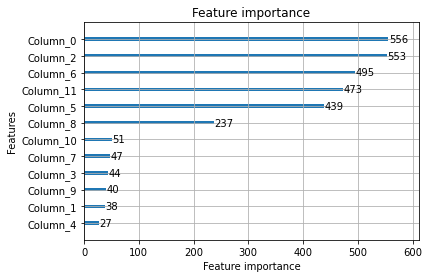

In [16]:
## sklearn接口

X,y = make_regression(n_samples=10000,n_features=12,n_informative=6 ,random_state=2022)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2022)

lgb_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression', # 默认是二分类
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=2022,
    silent=True
)


lgb_model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=100, early_stopping_rounds=50)

# 对测试集进行预测
y_pred = lgb_model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print('mse', mse)

# 显示重要特征
plot_importance(lgb_model)
plt.show()

In [17]:
## 原生接口

params = {
    'booster': 'gbtree',
    'objective': 'regression',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.01,
    'seed': 0
}


# 构造训练集
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)
num_rounds = 500

# 训练
model = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

# 预测
y_pred = model.predict(X_test,num_iteration=model.best_iteration)
print('mse:', mean_squared_error(y_test, y_pred))


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] Start training from score 2.522089
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 109.09	valid_1's l2: 

## 任务4：模型可视化

- 步骤1 ：安装graphviz
https://blog.csdn.net/m0_55099488/article/details/118685625
如果在AI Studio平台可以使用pip install graphviz完成安装，重启Notebook即可使用。
- 步骤2 ：将树模型预测结果进行可视化，并将结果保存为图像，https://blog.csdn.net/kyle1314608/article/details/111245782
- 步骤3（扩展） ：在任务2中我们保存了json版本的树模型，其中一家包含了每棵树的结构，你可以手动读取后，试试吗？

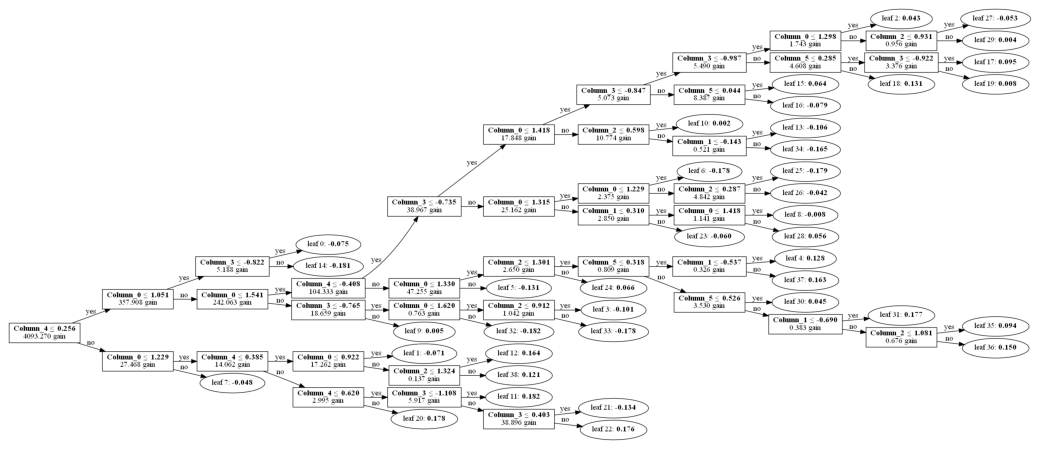

In [18]:
lgb.plot_tree(lgb_model_binary, tree_index=1, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [23]:
# import pydotplus
from IPython.display import Image
# 在环境变量中加入安装的Graphviz路径
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot_data  = lgb.create_tree_digraph(lgb_model_binary, tree_index=1)

# 结果保存为图像
dot_data.format='jpg'
dot_data.render('lgb_tree.jpg')

'lgb_tree.jpg.jpg'

## 任务5：模型调参（网格、随机、贝叶斯）

- 步骤1 ：运行以下代码得到训练集和验证集
- 步骤2 ：构建LightGBM分类器，并设置树模型深度分别为[3,5,6,9]，设置训练集和验证集，分别记录下验证集AUC精度。
- 步骤3 ：构建LightGBM分类器，在fit函数中将category变量设置为categorical_feature，训练并记录下分别记录下验证集AUC精度。
  - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier.fit
  - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train
- 步骤4 ：学习网格搜索原理，使用GridSearchCV完成其他超参数搜索，其他超参数设置可以选择learning_rate、num_leaves等。
- 步骤5 ：学习随机搜索原理，使用GridSearchCV完成其他超参数搜索，其他超参数设置可以选择learning_rate、num_leaves等。
- 步骤6 ：学习贝叶斯调参原理，使用BayesianOptimization完成超参数搜索，具体过程可以参考
  - https://blog.csdn.net/qq_42283960/article/details/88317003

In [1]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split
# 读取数据
data = pd.read_csv("https://cdn.coggle.club/kaggle-flight-delays/flights_10k.csv.zip")

# 提取有用的列
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

# 筛选出部分数据
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1
data1 = data.copy()
data2 = data.copy()

最大深度为：3
模型auc：0.6082106174458285
最大深度为：5
模型auc：0.6237350177349673
最大深度为：6
模型auc：0.6359792895926841
最大深度为：9
模型auc：0.6344558474960916


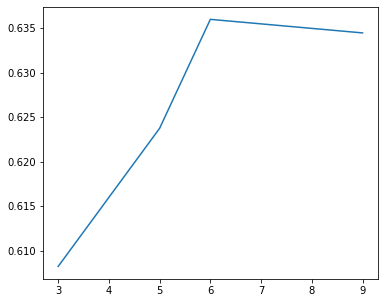

In [4]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score,accuracy_score,auc,mean_squared_error,roc_auc_score
import matplotlib.pyplot as plt


# 类别特征编码
# 参考 https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#unioning
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data1[item] = data1[item].astype("category").cat.codes +1

# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data1.drop(["ARRIVAL_DELAY"], axis=1), data1["ARRIVAL_DELAY"], random_state=10, test_size=0.25)

max_depth_num = [3,5,6,9]
auc = []
for max_depth in max_depth_num:
    lgb_model = lgb.LGBMClassifier(objective='binary',
                                   metric='auc',
                                   boosting_type='gbdt',
                                   n_estimators=100,
                                   learning_rate=0.2,
                                   n_jobs=-1,
                                   random_state=2022,
                                   max_depth=max_depth
                                   )

    print(f'最大深度为：{max_depth}')
    lgb_model.fit(train,y_train)
    y_pre = lgb_model.predict(test)
    # print('预测值：{}'.format(y_pre))
    print('模型auc：{}'.format(roc_auc_score(y_test,y_pre)))
    auc.append(roc_auc_score(y_test,y_pre))

plt.figure(figsize=[6,5])
plt.plot(max_depth_num,auc)
plt.show();


最大深度为：3
模型auc：0.6256965807655454
最大深度为：5
模型auc：0.6342488695008993
最大深度为：6
模型auc：0.6328714677156353
最大深度为：9
模型auc：0.6229985122799939


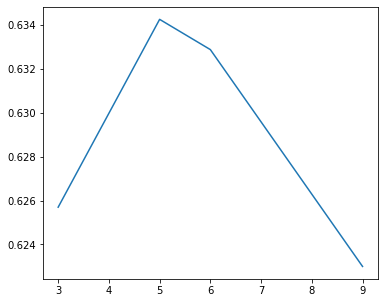

In [5]:
# 对类别特征，先做label encoding,再设置categorical_feature

cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]

for item in cols:
    data2[item] = data2[item].astype("category").cat.codes +1
# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data2.drop(["ARRIVAL_DELAY"], axis=1), data2["ARRIVAL_DELAY"], random_state=10, test_size=0.25)


max_depth_num = [3,5,6,9]
auc = []
for max_depth in max_depth_num:
    lgb_model = lgb.LGBMClassifier(objective='binary',
                                   metric='auc',
                                   boosting_type='gbdt',
                                   n_estimators=100,
                                   learning_rate=0.2,
                                   n_jobs=-1,
                                   random_state=2022,
                                   max_depth=max_depth
                                   )

    print(f'最大深度为：{max_depth}')
    lgb_model.fit(train,
                  y_train,
                  categorical_feature=["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
                  )
    
    y_pre = lgb_model.predict(test)
    # print('预测值：{}'.format(y_pre))
    print('模型auc：{}'.format(roc_auc_score(y_test,y_pre)))
    auc.append(roc_auc_score(y_test,y_pre))
    
plt.figure(figsize=[6,5])
plt.plot(max_depth_num,auc)
plt.show();


### 网格搜索

In [6]:

# 指定参数值的一种穷举搜索方法，通过将估计函数的参数通过交叉验证的方法进行优化来得到最优的学习算法。
# 将各个参数可能的取值进行排列组合，列出所有可能的组合结果生成“网格”。然后将各组合用于训练，并使用交叉验证对表现进行评估。
# 在拟合函数尝试了所有的参数组合后，返回一个合适的分类器，自动调整至最佳参数组合，可以通过clf.best_params_获得参数值

from sklearn.model_selection import GridSearchCV 

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40],
    'num_leaves':[30,50,70]
}

estimator = lgb.LGBMRegressor()
gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(train, y_train)

print(f'网格搜索最佳参数: {gbm.best_params_}')

网格搜索最佳参数: {'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 30}


### 随机搜索

In [16]:


# 以随机在参数空间中采样的方式代替了GridSearchCV对于参数的网格搜索，
# 在对于有连续变量的参数时，RandomizedSearchCV会将其当作一个分布进行采样,这是网格搜索做不到的，它的搜索能力取决于设定的n_iter参数
# 参考https://zhuanlan.zhihu.com/p/56010146#/

'''
（a）对于搜索范围是distribution的超参数，根据给定的distribution随机采样；
（b）对于搜索范围是list的超参数，在给定的list中等概率采样；
（c）对a、b两步中得到的n_iter组采样结果，进行遍历。
（补充）如果给定的搜索范围均为list，则不放回抽样n_iter次。
'''

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, 5],                        #给定list
              "max_features": sp_randint(1, 11),          #给定distribution
              "min_samples_split": sp_randint(2, 11),     #给定distribution
              "bootstrap": [True, False],                 #给定list
              "criterion": ["gini", "entropy"]
              }           #给定list

# n_iter: 随机寻找参数组合的数量
estimator = lgb.LGBMRegressor()
grid = RandomizedSearchCV(estimator=estimator,
                          param_distributions=param_dist,
                          cv=3,
                          n_iter=20, 
                          random_state=2022)

grid.fit(train, y_train)
print(f'随机搜索最佳参数: {grid.best_params_}')

[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[Li

### 贝叶斯

In [35]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# 参考：https://zhuanlan.zhihu.com/p/131216861#/
# 先定义目标函数
def lgb_cv(learning_rate,max_depth):
    estimator = lgb.LGBMRegressor(learning_rate=learning_rate,
                                max_depth=int(max_depth),
                                random_state=2022
                                )

    cross_val = cross_val_score(estimator=estimator,X=train,y=y_train,cv=3,scoring='roc_auc').mean()
    return cross_val


# 输入目标函数，需要优化的参数的范围
grid_bayes = BayesianOptimization(
    f=lgb_cv,
    pbounds={"learning_rate": (0.01, 0.05),
             "max_depth": (2, 5)
             },
    random_state=2022,
    verbose=2
)

# 开始优化
grid_bayes.maximize()


# 最优参数
grid_bayes.max

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
|  1        |  0.6754   |  0.01037  |  3.497    |
|  2        |  0.6571   |  0.01454  |  2.15     |
|  3        |  0.719    |  0.03742  |  3.461    |
|  4        |  0.7261   |  0.04591  |  3.942    |
|  5        |  0.7353   |  0.04588  |  4.163    |
|  6        |  0.6713   |  0.01901  |  2.798    |
|  7        |  0.711    |  0.02964  |  3.049    |
|  8        |  0.6747   |  0.02064  |  2.952    |
|  9        |  0.7352   |  0.04602  |  4.163    |
|  10       |  0.6904   |  0.01     |  4.14     |
|  11       |  0.735    |  0.04799  |  4.191    |
|  12       |  0.6996   |  0.02114  |  3.755    |
|  13       |  0.6939   |  0.01129  |  4.202    |
|  14       |  0.6747   |  0.01005  |  3.956    |
|  15       |  0.6996   |  0.01439  |  4.398    |
|  16       |  0.7262   |  0.0487   |  3.915    |
|  17       |  0.7239   |  0.04462  |  3.424    |
|  18       |  0.6744   |  0.01     |  3.425    |


{'target': 0.7370723978392687,
 'params': {'learning_rate': 0.05, 'max_depth': 4.221053633256363}}